In [1]:
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm

In [2]:
session=cc.database.create_session()

In [3]:
client = Client()
client

distributed.diskutils - INFO - Found stale lock file and directory '/local/g40/hm1221/tmp/dask-worker-space/worker-3drogvg6', purging
distributed.diskutils - INFO - Found stale lock file and directory '/local/g40/hm1221/tmp/dask-worker-space/worker-a0vh20qd', purging
distributed.diskutils - INFO - Found stale lock file and directory '/local/g40/hm1221/tmp/dask-worker-space/worker-opuk977z', purging
distributed.diskutils - INFO - Found stale lock file and directory '/local/g40/hm1221/tmp/dask-worker-space/worker-_te8cl3_', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43505,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:38649,Total threads: 4
Dashboard: /proxy/38245/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:37183,


In [4]:
# time period
start_time = '1995-01-01'
end_time = '2000-01-01'

# 0.1 deg resolution

In [5]:
# load umo and rho
umo = cc.querying.getvar('01deg_jra55v13_iaf','tx_trans_rho', session, start_time=start_time, end_time=end_time).sel(time = slice(start_time,end_time))
rho = cc.querying.getvar('01deg_jra55v13_iaf','pot_rho_2',session,start_time=start_time, end_time=end_time).sel(time = slice(start_time,end_time))

In [6]:
#dz
dz = cc.querying.getvar('01deg_jra55v13_iaf','dzt', session, start_time=start_time, end_time=end_time).sel(time = slice(start_time,end_time))

In [7]:
umo = umo.sel(grid_yt_ocean = slice(-90,-50)).mean('time')
rho = rho.sel(yt_ocean = slice(-90,-50)).mean('time')
dz = dz.sel(yt_ocean = slice(-90,-50)).mean('time')

In [8]:
umo

<xarray.DataArray 'tx_trans_rho' (potrho: 80, grid_yt_ocean: 666, grid_xu_ocean: 3600)>
dask.array<mean_agg-aggregate, shape=(80, 666, 3600), dtype=float32, chunksize=(8, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * grid_xu_ocean  (grid_xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.9 80.0
  * grid_yt_ocean  (grid_yt_ocean) float64 -81.11 -81.07 ... -50.09 -50.03
  * potrho         (potrho) float64 1.028e+03 1.028e+03 ... 1.038e+03 1.038e+03

In [9]:
# set different density layers
rho1 = 1037.06
rho2 = 1037.10
rho3 = 1037.20

In [10]:
# lower than 1037.06
flux1 = (umo.sel(potrho=slice(0,rho1)).cumsum('grid_yt_ocean').sum('potrho')/1e9).load()
# 1037.06 - 1037.10
flux2 = (umo.sel(potrho=slice(rho1,rho2)).cumsum('grid_yt_ocean').sum('potrho')/1e9).load()
# 1037.10 - 1037.20
flux3 = (umo.sel(potrho=slice(rho2,rho3)).cumsum('grid_yt_ocean').sum('potrho')/1e9).load()
# 1037.20-
flux4 = (umo.sel(potrho=slice(rho3,2000.)).cumsum('grid_yt_ocean').sum('potrho')/1e9).load()

In [11]:
x1=-30
#filter the layers
density1 = rho.sel(xt_ocean=x1,method='nearest')
dz1 = dz.sel(xt_ocean=x1,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x1,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x1,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x1,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth1 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes1 = np.stack([flux1.sel(grid_xu_ocean=x1,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x1,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x1,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x1,method='nearest').values])

In [12]:
x2=0
#filter the layers
density1 = rho.sel(xt_ocean=x2,method='nearest')
dz1 = dz.sel(xt_ocean=x2,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x2,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x2,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x2,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth2 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes2 = np.stack([flux1.sel(grid_xu_ocean=x2,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x2,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x2,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x2,method='nearest').values])

In [13]:
x3=30
#filter the layers
density1 = rho.sel(xt_ocean=x3,method='nearest')
dz1 = dz.sel(xt_ocean=x3,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x3,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x3,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x3,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth3 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes3 = np.stack([flux1.sel(grid_xu_ocean=x3,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x3,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x3,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x3,method='nearest').values])

In [14]:
x4=75
#filter the layers
density1 = rho.sel(xt_ocean=x4,method='nearest')
dz1 = dz.sel(xt_ocean=x4,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x4,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x4,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x4,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth4 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes4= np.stack([flux1.sel(grid_xu_ocean=x4,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x4,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x4,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x4,method='nearest').values])

In [15]:
x5=-270
#filter the layers
density1 = rho.sel(xt_ocean=x5,method='nearest')
dz1 = dz.sel(xt_ocean=x5,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x5,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x5,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x5,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth5 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes5 = np.stack([flux1.sel(grid_xu_ocean=x5,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x5,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x5,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x5,method='nearest').values])

In [16]:
x6=-210
#filter the layers
density1 = rho.sel(xt_ocean=x6,method='nearest')
dz1 = dz.sel(xt_ocean=x6,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x6,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x6,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x6,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth6 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes6 = np.stack([flux1.sel(grid_xu_ocean=x6,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x6,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x6,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x6,method='nearest').values])

In [17]:
x7=-180
#filter the layers
density1 = rho.sel(xt_ocean=x7,method='nearest')
dz1 = dz.sel(xt_ocean=x7,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x7,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x7,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x7,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth7 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes7 = np.stack([flux1.sel(grid_xu_ocean=x7,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x7,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x7,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x7,method='nearest').values])

In [18]:
x8=-150
#filter the layers
density1 = rho.sel(xt_ocean=x8,method='nearest')
dz1 = dz.sel(xt_ocean=x8,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x8,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x8,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x8,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth8 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes8 = np.stack([flux1.sel(grid_xu_ocean=x8,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x8,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x8,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x8,method='nearest').values])

In [19]:
x9=-130
#filter the layers
density1 = rho.sel(xt_ocean=x9,method='nearest')
dz1 = dz.sel(xt_ocean=x9,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x9,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x9,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x9,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth9 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes9 = np.stack([flux1.sel(grid_xu_ocean=x9,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x9,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x9,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x9,method='nearest').values])

In [25]:
# set the line color
c = ['k','r','b','m','k']
label=['0','1037.06','1037.10','1037.20','0']

Text(0, 0.5, 'streamfunction (Sv)')

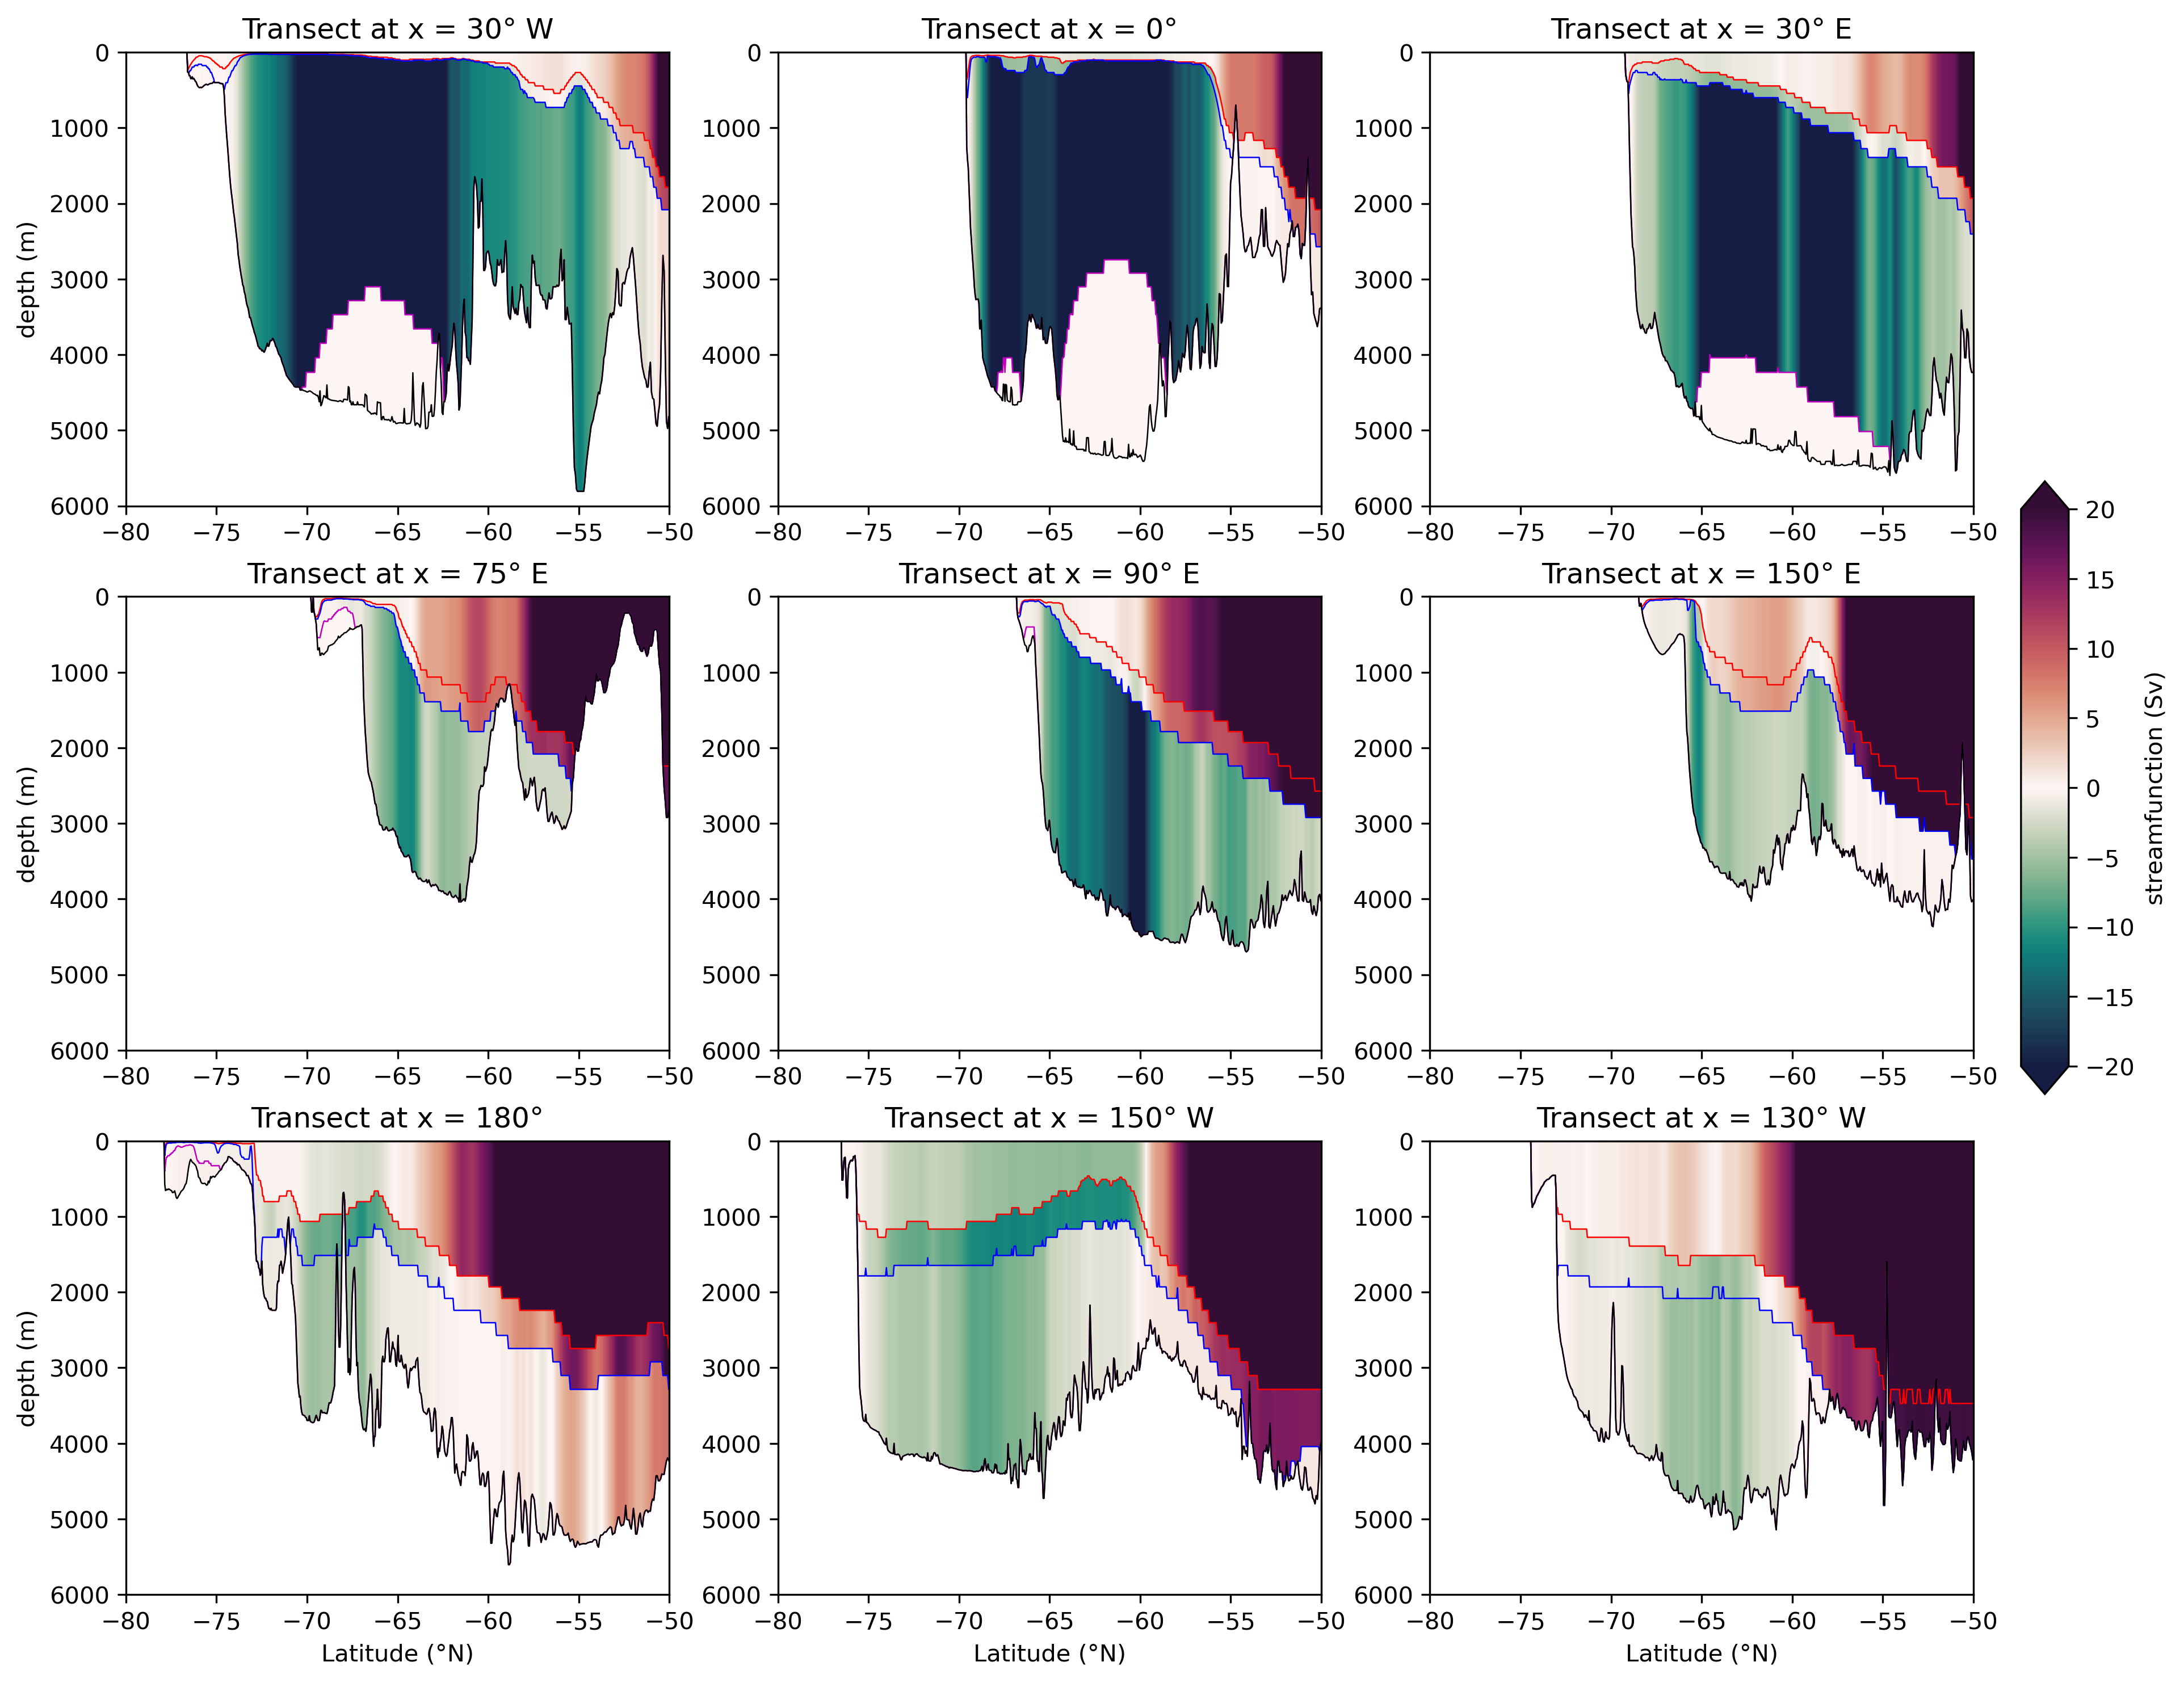

In [26]:
plt.figure(figsize=(14,12),dpi = 300)
# 30W
plt.subplot(3,3,1)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth1,fluxes1[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth1[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 30° W')
plt.xlim(-80,-50)
plt.ylabel('depth (m)')



# 0
plt.subplot(3,3,2)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth2,fluxes2[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth2[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 0°')
plt.xlim(-80,-50)


# 30E
plt.subplot(3,3,3)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth3,fluxes3[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth3[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 30° E')
plt.xlim(-80,-50)


# 75E
plt.subplot(3,3,4)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth4,fluxes4[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth4[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 75° E')
plt.xlim(-80,-50)
plt.ylabel('depth (m)')


# 90E
plt.subplot(3,3,5)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth5,fluxes5[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth5[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 90° E')
plt.xlim(-80,-50)

# 150E
plt.subplot(3,3,6)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth6,fluxes6[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth6[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 150° E')
plt.xlim(-80,-50)


# 180
plt.subplot(3,3,7)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth7,fluxes7[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth7[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 180°')
plt.xlim(-80,-50)
plt.ylabel('depth (m)')
plt.xlabel('Latitude (°N)')

# 150W
plt.subplot(3,3,8)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth8,fluxes8[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth8[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 150° W')
plt.xlim(-80,-50)
plt.xlabel('Latitude (°N)')

# 130W
plt.subplot(3,3,9)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth9,fluxes9[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth9[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 130° W')
plt.xlim(-80,-50)
plt.xlabel('Latitude (°N)')

# add colorbar
ax = plt.axes([0.92, 0.37, 0.02, 0.3])
cb = plt.colorbar(p1, cax=ax, orientation='vertical',extend = 'both')
cb.ax.set_ylabel('streamfunction (Sv)')


# 0.25 deg resolution

In [27]:
# load umo and rho
umo = cc.querying.getvar('025deg_jra55v13_iaf_gmredi6','tx_trans_rho', session, start_time=start_time, end_time=end_time).sel(time = slice(start_time,end_time))
rho = cc.querying.getvar('025deg_jra55v13_iaf_gmredi6','pot_rho_2',session,start_time=start_time, end_time=end_time).sel(time = slice(start_time,end_time))
#dz
dz = cc.querying.getvar('025deg_jra55v13_iaf_gmredi6','dzt', session, start_time=start_time, end_time=end_time).sel(time = slice(start_time,end_time))

In [28]:
umo = umo.sel(grid_yt_ocean = slice(-90,-50)).mean('time')
rho = rho.sel(yt_ocean = slice(-90,-50)).mean('time')
dz = dz.sel(yt_ocean = slice(-90,-50)).mean('time')

In [29]:
umo

<xarray.DataArray 'tx_trans_rho' (potrho: 80, grid_yt_ocean: 266, grid_xu_ocean: 1440)>
dask.array<mean_agg-aggregate, shape=(80, 266, 1440), dtype=float32, chunksize=(14, 216, 288), chunktype=numpy.ndarray>
Coordinates:
  * grid_xu_ocean  (grid_xu_ocean) float64 -279.8 -279.5 -279.2 ... 79.75 80.0
  * grid_yt_ocean  (grid_yt_ocean) float64 -81.08 -80.97 -80.87 ... -50.3 -50.14
  * potrho         (potrho) float64 1.028e+03 1.028e+03 ... 1.038e+03 1.038e+03

In [30]:
# lower than 1037.06
flux1 = (umo.sel(potrho=slice(0,rho1)).cumsum('grid_yt_ocean').sum('potrho')/1e9).load()
# 1037.06 - 1037.10
flux2 = (umo.sel(potrho=slice(rho1,rho2)).cumsum('grid_yt_ocean').sum('potrho')/1e9).load()
# 1037.10 - 1037.20
flux3 = (umo.sel(potrho=slice(rho2,rho3)).cumsum('grid_yt_ocean').sum('potrho')/1e9).load()
# 1037.20-
flux4 = (umo.sel(potrho=slice(rho3,2000.)).cumsum('grid_yt_ocean').sum('potrho')/1e9).load()

In [31]:
x1=-30
#filter the layers
density1 = rho.sel(xt_ocean=x1,method='nearest')
dz1 = dz.sel(xt_ocean=x1,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x1,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x1,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x1,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth1 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes1 = np.stack([flux1.sel(grid_xu_ocean=x1,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x1,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x1,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x1,method='nearest').values])

In [32]:
x2=0
#filter the layers
density1 = rho.sel(xt_ocean=x2,method='nearest')
dz1 = dz.sel(xt_ocean=x2,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x2,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x2,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x2,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth2 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes2 = np.stack([flux1.sel(grid_xu_ocean=x2,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x2,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x2,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x2,method='nearest').values])

In [33]:
x3=30
#filter the layers
density1 = rho.sel(xt_ocean=x3,method='nearest')
dz1 = dz.sel(xt_ocean=x3,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x3,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x3,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x3,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth3 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes3 = np.stack([flux1.sel(grid_xu_ocean=x3,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x3,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x3,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x3,method='nearest').values])

In [34]:
x4=75
#filter the layers
density1 = rho.sel(xt_ocean=x4,method='nearest')
dz1 = dz.sel(xt_ocean=x4,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x4,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x4,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x4,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth4 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes4 = np.stack([flux1.sel(grid_xu_ocean=x4,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x4,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x4,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x4,method='nearest').values])

In [35]:
x5=-270
#filter the layers
density1 = rho.sel(xt_ocean=x5,method='nearest')
dz1 = dz.sel(xt_ocean=x5,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x5,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x5,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x5,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth5 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes5 = np.stack([flux1.sel(grid_xu_ocean=x5,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x5,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x5,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x5,method='nearest').values])

In [36]:
x6=-210
#filter the layers
density1 = rho.sel(xt_ocean=x6,method='nearest')
dz1 = dz.sel(xt_ocean=x6,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x6,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x6,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x6,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth6 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes6 = np.stack([flux1.sel(grid_xu_ocean=x6,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x6,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x6,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x6,method='nearest').values])

In [37]:
x7=-180
#filter the layers
density1 = rho.sel(xt_ocean=x7,method='nearest')
dz1 = dz.sel(xt_ocean=x7,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x7,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x7,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x7,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth7 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes7 = np.stack([flux1.sel(grid_xu_ocean=x7,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x7,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x7,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x7,method='nearest').values])

In [38]:
x8=-150
#filter the layers
density1 = rho.sel(xt_ocean=x8,method='nearest')
dz1 = dz.sel(xt_ocean=x8,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x8,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x8,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x8,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth8 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes8 = np.stack([flux1.sel(grid_xu_ocean=x8,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x8,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x8,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x8,method='nearest').values])

In [39]:
x9=-130
#filter the layers
density1 = rho.sel(xt_ocean=x9,method='nearest')
dz1 = dz.sel(xt_ocean=x9,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x9,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x9,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x9,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth9 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes9 = np.stack([flux1.sel(grid_xu_ocean=x9,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x9,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x9,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x9,method='nearest').values])

Text(0, 0.5, 'streamfunction (Sv)')

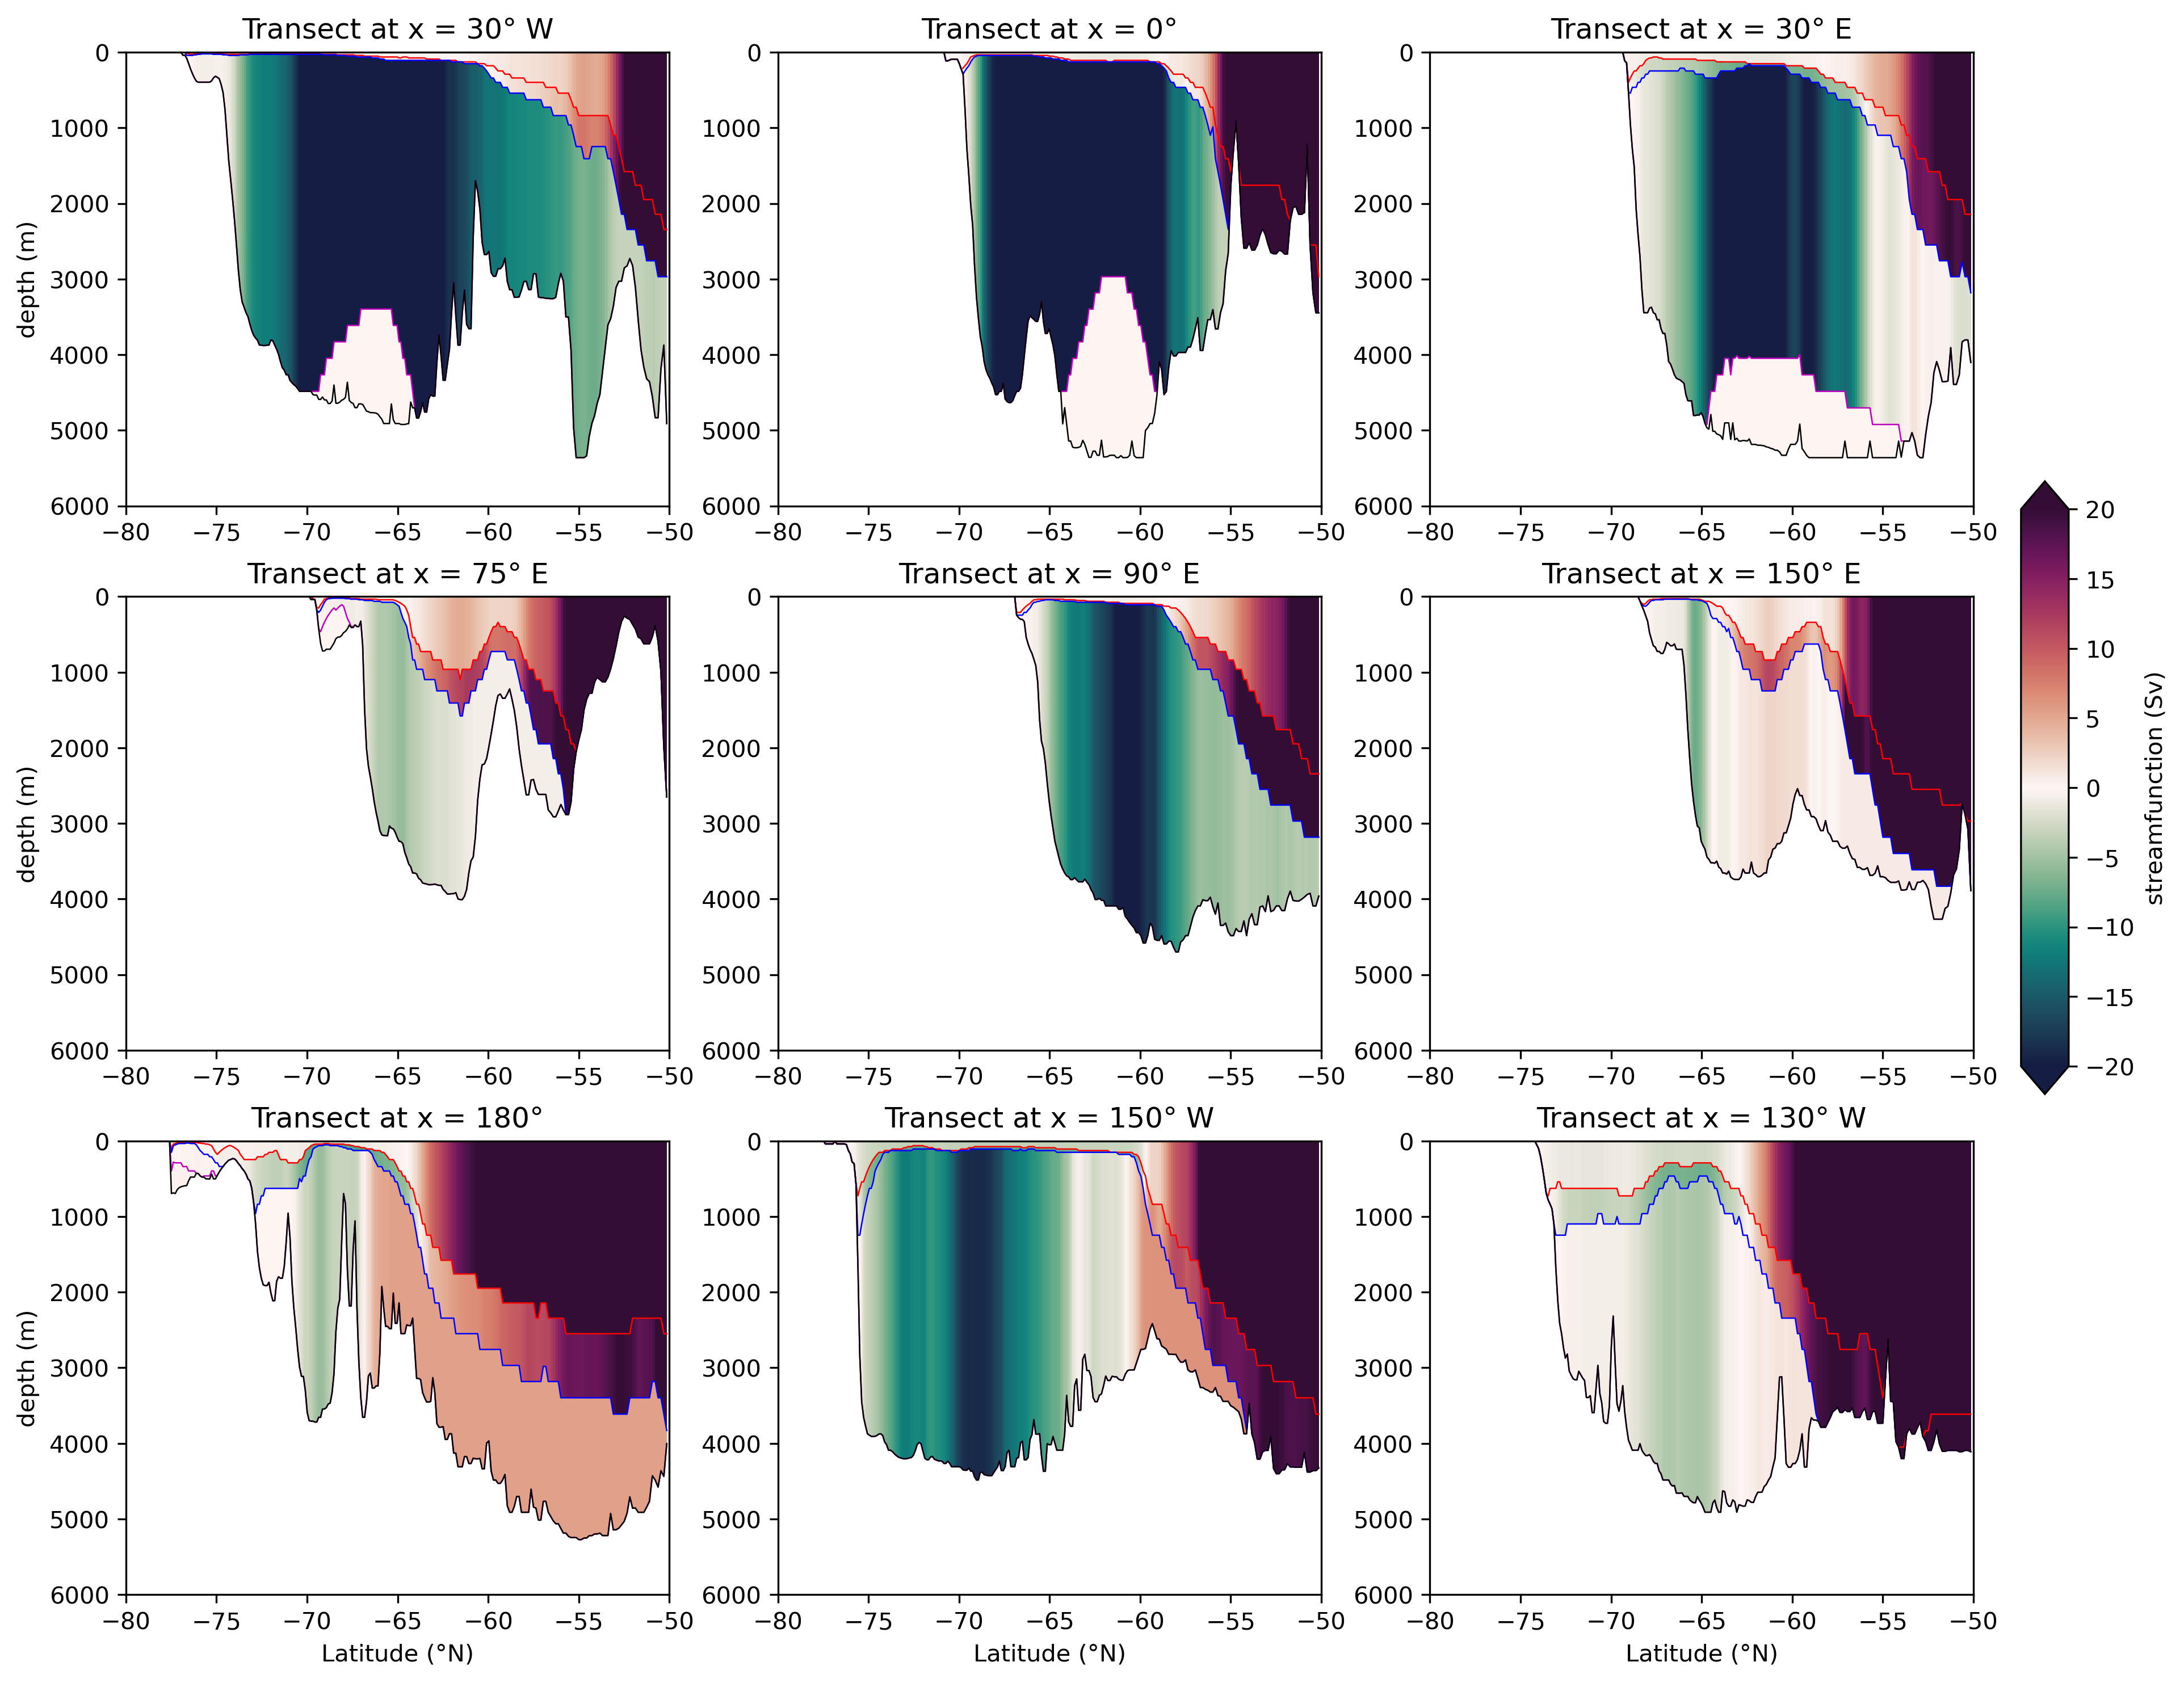

In [41]:
plt.figure(figsize=(14,12),dpi = 300)
# 30W
plt.subplot(3,3,1)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth1,fluxes1[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth1[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 30° W')
plt.xlim(-80,-50)
plt.ylabel('depth (m)')



# 0
plt.subplot(3,3,2)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth2,fluxes2[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth2[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 0°')
plt.xlim(-80,-50)


# 30E
plt.subplot(3,3,3)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth3,fluxes3[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth3[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 30° E')
plt.xlim(-80,-50)


# 75E
plt.subplot(3,3,4)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth4,fluxes4[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth4[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 75° E')
plt.xlim(-80,-50)
plt.ylabel('depth (m)')


# 90E
plt.subplot(3,3,5)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth5,fluxes5[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth5[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 90° E')
plt.xlim(-80,-50)

# 150E
plt.subplot(3,3,6)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth6,fluxes6[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth6[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 150° E')
plt.xlim(-80,-50)


# 180
plt.subplot(3,3,7)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth7,fluxes7[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth7[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 180°')
plt.xlim(-80,-50)
plt.ylabel('depth (m)')
plt.xlabel('Latitude (°N)')

# 150W
plt.subplot(3,3,8)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth8,fluxes8[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth8[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 150° W')
plt.xlim(-80,-50)
plt.xlabel('Latitude (°N)')

# 130W
plt.subplot(3,3,9)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth9,fluxes9[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth9[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 130° W')
plt.xlim(-80,-50)
plt.xlabel('Latitude (°N)')

# add colorbar
ax = plt.axes([0.92, 0.37, 0.02, 0.3])
cb = plt.colorbar(p1, cax=ax, orientation='vertical',extend = 'both')
cb.ax.set_ylabel('streamfunction (Sv)')


# 1 deg resolution 

In [47]:
# load umo and rho
umo = cc.querying.getvar('1deg_jra55v13_iaf_spinup1_B1','tx_trans_rho', session, start_time=start_time, end_time=end_time).sel(time = slice(start_time,end_time))
rho = cc.querying.getvar('1deg_jra55v13_iaf_spinup1_B1','pot_rho_2',session,start_time=start_time, end_time=end_time).sel(time = slice(start_time,end_time))
#dz
dz = cc.querying.getvar('1deg_jra55v13_iaf_spinup1_B1','dzt', session, start_time=start_time, end_time=end_time).sel(time = slice(start_time,end_time))

In [48]:
umo = umo.sel(grid_yt_ocean = slice(-90,-50)).mean('time')
rho = rho.sel(yt_ocean = slice(-90,-50)).mean('time')
dz = dz.sel(yt_ocean = slice(-90,-50)).mean('time')

In [49]:
umo

<xarray.DataArray 'tx_trans_rho' (potrho: 80, grid_yt_ocean: 56, grid_xu_ocean: 360)>
dask.array<mean_agg-aggregate, shape=(80, 56, 360), dtype=float32, chunksize=(27, 56, 120), chunktype=numpy.ndarray>
Coordinates:
  * grid_xu_ocean  (grid_xu_ocean) float64 -279.0 -278.0 -277.0 ... 79.0 80.0
  * grid_yt_ocean  (grid_yt_ocean) float64 -77.88 -77.63 -77.38 ... -51.36 -50.5
  * potrho         (potrho) float64 1.028e+03 1.028e+03 ... 1.038e+03 1.038e+03

In [50]:
# lower than 1037.06
flux1 = (umo.sel(potrho=slice(0,rho1)).cumsum('grid_yt_ocean').sum('potrho')/1e9).load()
# 1037.06 - 1037.10
flux2 = (umo.sel(potrho=slice(rho1,rho2)).cumsum('grid_yt_ocean').sum('potrho')/1e9).load()
# 1037.10 - 1037.20
flux3 = (umo.sel(potrho=slice(rho2,rho3)).cumsum('grid_yt_ocean').sum('potrho')/1e9).load()
# 1037.20-
flux4 = (umo.sel(potrho=slice(rho3,2000.)).cumsum('grid_yt_ocean').sum('potrho')/1e9).load()

In [51]:
x1=-30
#filter the layers
density1 = rho.sel(xt_ocean=x1,method='nearest')
dz1 = dz.sel(xt_ocean=x1,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x1,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x1,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x1,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth1 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes1 = np.stack([flux1.sel(grid_xu_ocean=x1,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x1,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x1,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x1,method='nearest').values])

In [52]:
x2=0
#filter the layers
density1 = rho.sel(xt_ocean=x2,method='nearest')
dz1 = dz.sel(xt_ocean=x2,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x2,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x2,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x2,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth2 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes2 = np.stack([flux1.sel(grid_xu_ocean=x2,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x2,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x2,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x2,method='nearest').values])

In [53]:
x3=30
#filter the layers
density1 = rho.sel(xt_ocean=x3,method='nearest')
dz1 = dz.sel(xt_ocean=x3,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x3,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x3,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x3,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth3 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes3 = np.stack([flux1.sel(grid_xu_ocean=x3,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x3,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x3,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x3,method='nearest').values])

In [54]:
x4=75
#filter the layers
density1 = rho.sel(xt_ocean=x4,method='nearest')
dz1 = dz.sel(xt_ocean=x4,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x4,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x4,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x4,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth4 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes4 = np.stack([flux1.sel(grid_xu_ocean=x4,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x4,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x4,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x4,method='nearest').values])

In [55]:
x5=-270
#filter the layers
density1 = rho.sel(xt_ocean=x5,method='nearest')
dz1 = dz.sel(xt_ocean=x5,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x5,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x5,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x5,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth5 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes5 = np.stack([flux1.sel(grid_xu_ocean=x5,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x5,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x5,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x5,method='nearest').values])

In [56]:
x6=-210
#filter the layers
density1 = rho.sel(xt_ocean=x6,method='nearest')
dz1 = dz.sel(xt_ocean=x6,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x6,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x6,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x6,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth6 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes6 = np.stack([flux1.sel(grid_xu_ocean=x6,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x6,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x6,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x6,method='nearest').values])

In [57]:
x7=-180
#filter the layers
density1 = rho.sel(xt_ocean=x7,method='nearest')
dz1 = dz.sel(xt_ocean=x7,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x7,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x7,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x7,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth7 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes7 = np.stack([flux1.sel(grid_xu_ocean=x7,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x7,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x7,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x7,method='nearest').values])

In [58]:
x8=-150
#filter the layers
density1 = rho.sel(xt_ocean=x8,method='nearest')
dz1 = dz.sel(xt_ocean=x8,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x8,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x8,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x8,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth8 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes8 = np.stack([flux1.sel(grid_xu_ocean=x8,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x8,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x8,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x8,method='nearest').values])

In [59]:
x9=-130
#filter the layers
density1 = rho.sel(xt_ocean=x9,method='nearest')
dz1 = dz.sel(xt_ocean=x9,method='nearest').where(density1<rho1).load()
dz2 = dz.sel(xt_ocean=x9,method='nearest').where(density1>rho1).where(density1<rho2).load()
dz3 = dz.sel(xt_ocean=x9,method='nearest').where(density1>rho2).where(density1<rho3).load()
dz4 = dz.sel(xt_ocean=x9,method='nearest').where(density1>rho3).load()
# calculate the layer thickness
h1 = dz1.sum('st_ocean').load()
h2 = dz2.sum('st_ocean').load()
h3 = dz3.sum('st_ocean').load()
h4 = dz4.sum('st_ocean').load()

# set the different layers
depth9 = np.stack([0.0*h1.values,
                   h1.values,
                   (h1+h2).values,
                   (h1+h2+h3).values,
                   (h1+h2+h3+h4).values])
fluxes9 = np.stack([flux1.sel(grid_xu_ocean=x9,method='nearest').values,
                   flux2.sel(grid_xu_ocean=x9,method='nearest').values,
                    flux3.sel(grid_xu_ocean=x9,method='nearest').values,
                    flux4.sel(grid_xu_ocean=x9,method='nearest').values])

Text(0, 0.5, 'streamfunction (Sv)')

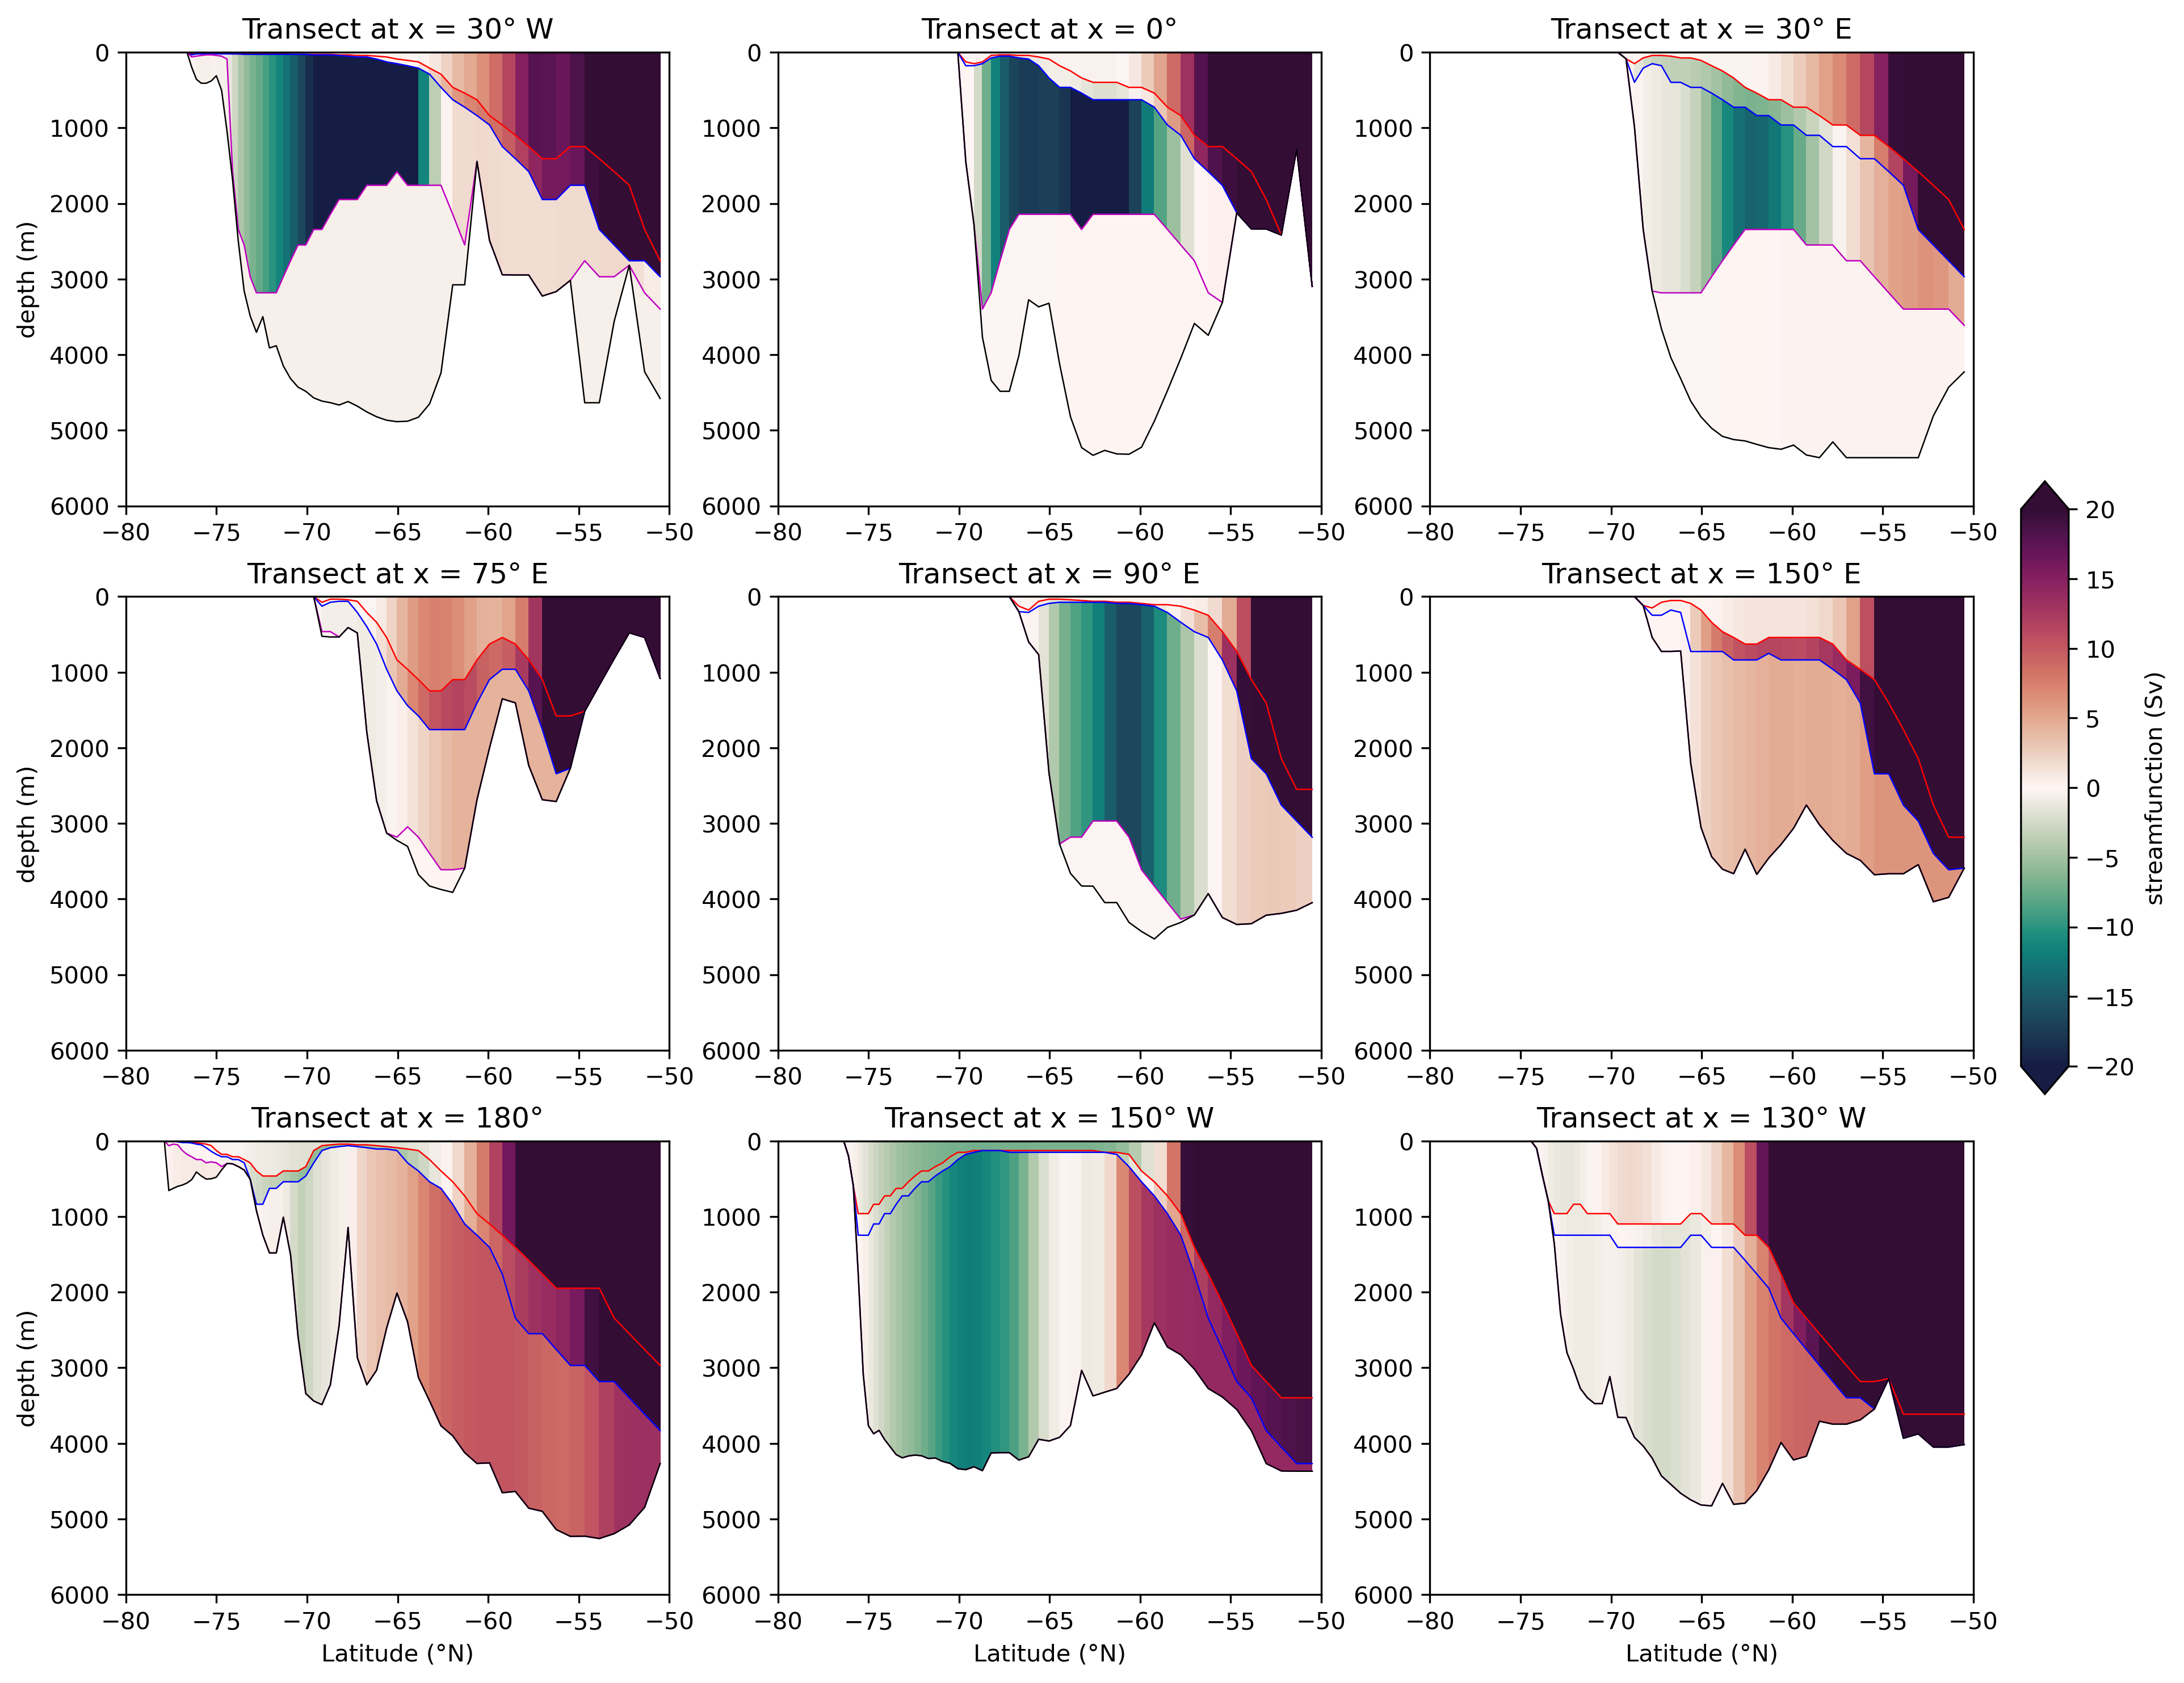

In [61]:
plt.figure(figsize=(14,12),dpi = 300)
# 30W
plt.subplot(3,3,1)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth1,fluxes1[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth1[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 30° W')
plt.xlim(-80,-50)
plt.ylabel('depth (m)')



# 0
plt.subplot(3,3,2)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth2,fluxes2[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth2[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 0°')
plt.xlim(-80,-50)


# 30E
plt.subplot(3,3,3)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth3,fluxes3[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth3[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 30° E')
plt.xlim(-80,-50)


# 75E
plt.subplot(3,3,4)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth4,fluxes4[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth4[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 75° E')
plt.xlim(-80,-50)
plt.ylabel('depth (m)')


# 90E
plt.subplot(3,3,5)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth5,fluxes5[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth5[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 90° E')
plt.xlim(-80,-50)

# 150E
plt.subplot(3,3,6)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth6,fluxes6[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth6[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 150° E')
plt.xlim(-80,-50)


# 180
plt.subplot(3,3,7)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth7,fluxes7[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth7[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 180°')
plt.xlim(-80,-50)
plt.ylabel('depth (m)')
plt.xlabel('Latitude (°N)')

# 150W
plt.subplot(3,3,8)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth8,fluxes8[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth8[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 150° W')
plt.xlim(-80,-50)
plt.xlabel('Latitude (°N)')

# 130W
plt.subplot(3,3,9)
p1 = plt.pcolor(flux1.grid_yt_ocean.values,depth9,fluxes9[:,1:],shading='flat',vmin=-20,vmax=20,cmap=cm.cm.curl)
for ii in range(5):
    contours=plt.plot(flux1.grid_yt_ocean.values,depth9[ii,:],color = c[ii],label=label[ii],linewidth = 0.6)
plt.ylim(0,6000)
plt.gca().invert_yaxis()
plt.title('Transect at x = 130° W')
plt.xlim(-80,-50)
plt.xlabel('Latitude (°N)')

# add colorbar
ax = plt.axes([0.92, 0.37, 0.02, 0.3])
cb = plt.colorbar(p1, cax=ax, orientation='vertical',extend = 'both')
cb.ax.set_ylabel('streamfunction (Sv)')
